### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [25]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [26]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [27]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2019.csv')
df = df.iloc[::5, :]
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [20]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [41]:
df.tail()

,year,Post
7775,2019,5 simple tricks to calm your anxious mind | So...
7780,2019,"100 days to overcome depression, chronic pain ..."
7785,2019,When Mental Illness is EnvironmentalEveryone k...
7790,2019,DryCast like a failing argument over waterthe ...
7795,2019,Cannabis and Anxiety | City SessionsThe Human ...


In [22]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [23]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['my', 'year', 'without', 'boozedrinking', 'was', 'my', 'routine', 'booze', 'was', 'my', 'pattern', 'red', 'wine', 'while', 'cooked', 'dinner', 'whiskey', 'while', 'got', 'ready', 'to', 'go', 'out', 'more', 'wine', 'for', 'an', 'afternoon', 'in', 'the', 'park', 'every', 'occasion', 'revolved', 'around', 'drinking', 'felt', 'fatigued', 'around', 'the', 'holidays', 'many', 'peers', 'started', 'talking', 'about', 'doing', 'sober', 'january', 'the', 'first', 'thought', 'in', 'my', 'head', 'was', 'wow', 'that', 'sounds', 'really', 'hard', 'that', 'thought', 'led', 'to', 'the', 'realization', 'that', 'if', 'it', 'seemed', 'hard', 'maybe', 'it', 'was', 'necessary', 'this', 'time', 'last', 'year', 'decided', 'to', 'attempt', 'sober', 'january', 'as', 'january', 'started', 'yoga', 'classes', 'replaced', 'the', 'hours', 'would', 'have', 'spent', 'drinking', 'with', 'friends', 'spent', 'my', 'th', 'birthday', 'on', 'saturday', 'january', 'th', 'organizing', 'my', 'kitchen', 'and', 'listening', '

In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['my', 'year', 'without', 'boozedrinking', 'was', 'my', 'routine', 'booze', 'was', 'my', 'pattern', 'red', 'wine', 'while', 'cooked', 'dinner', 'whiskey', 'while', 'got', 'ready', 'to', 'go', 'out', 'more', 'wine', 'for', 'an', 'afternoon', 'in', 'the', 'park', 'every', 'occasion', 'revolved', 'around', 'drinking', 'felt', 'fatigued', 'around', 'the', 'holidays', 'many', 'peers', 'started', 'talking', 'about', 'doing', 'sober', 'january', 'the', 'first', 'thought', 'in', 'my', 'head', 'was', 'wow', 'that', 'sounds', 'really', 'hard', 'that', 'thought', 'led', 'to', 'the', 'realization', 'that', 'if', 'it', 'seemed', 'hard', 'maybe', 'it', 'was', 'necessary', 'this', 'time', 'last', 'year', 'decided', 'to', 'attempt', 'sober', 'january', 'as', 'january', 'started', 'yoga_classes', 'replaced', 'the', 'hours', 'would', 'have', 'spent', 'drinking', 'with', 'friends', 'spent', 'my', 'th_birthday', 'on', 'saturday', 'january', 'th', 'organizing', 'my', 'kitchen', 'and', 'listening', 'to', 'p

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
data_words_nostops = remove_stopwords(data_words)
print("1")
data_words_bigrams = make_bigrams(data_words_nostops)
print("2")

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm")

# 1. Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("3")

# 2. Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)
print("4")

# 3. Create Corpus
texts = data_lemmatized

# 4. Term Document Frequency and Create a bag of words
bow_corpus = bow(dictionary=id2word, processed_docs=texts)
print("5")

# 5. Calculate low_tfidf_words
# Keep only words with tfidf ranking <= x * len(dictionary)
x = 0.2
total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
print("6")
sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
print("7")
low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)
print("8")

# 6. Filter out least frequently used words
no_below = 0.02
keep_n = 10000
dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
                                                 no_below, keep_n)
print("9")

# 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)
print("10")

# 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# created after least frequently and most commonly used words were filtered out.
corpus = bow(dict_tfidf_filtered, texts)
print("11")

# View
[[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=26,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

1
2
3
4
5
6
7
8
There are 1872 unique words in the dictionary, 1872 remain after filtering out lest frequent.
9
1872 remain after filtering out most commonly used words based on tfidf scores.
10
11


In [29]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(24,
  '0.614*"god" + 0.162*"pray" + 0.000*"survey" + 0.000*"cultivate" + '
  '0.000*"youth" + 0.000*"lovely" + 0.000*"modern" + 0.000*"tap" + '
  '0.000*"uncontrollable" + 0.000*"rely"'),
 (25,
  '0.140*"drown" + 0.113*"clarity" + 0.101*"era" + 0.101*"pool" + '
  '0.083*"water" + 0.072*"sea" + 0.031*"burden" + 0.028*"ocean" + '
  '0.023*"deadline" + 0.016*"meet"'),
 (8,
  '0.224*"wait" + 0.072*"illusion" + 0.063*"odd" + 0.061*"fat" + '
  '0.055*"silence" + 0.051*"silent" + 0.051*"depress" + 0.046*"weigh" + '
  '0.031*"comfort" + 0.029*"crush"'),
 (5,
  '0.224*"social" + 0.102*"child" + 0.095*"parent" + 0.066*"generation" + '
  '0.064*"millennial" + 0.047*"party" + 0.042*"instagram" + 0.042*"parenting" '
  '+ 0.033*"event" + 0.026*"interaction"'),
 (11,
  '0.153*"yoga" + 0.094*"christmas" + 0.089*"gift" + 0.082*"routine" + '
  '0.080*"game" + 0.073*"coach" + 0.035*"meaningful" + 0.032*"blanket" + '
  '0.025*"item" + 0.022*"darkest"'),
 (23,
  '0.094*"social_media" + 0.075*"online" + 0

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.644308252204834


In [31]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.34652595304431394


In [32]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [33]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.3100,"kid, holiday, birthday, drink, wear, old, pull...","[year, boozedrinke, routine, booze, pattern, r..."
1,1,7.0,0.5119,"light, eat, room, listen, water, watch, sound,...","[short, storyrattle, uneven, sidewalk, bike, r..."
2,2,19.0,0.6095,"mental_health, relationship, support, result, ...","[high, stay, humble, low, stay, post, contain,..."
3,3,19.0,0.2337,"mental_health, relationship, support, result, ...","[live, adhdwhen, finally, diagnose, adhd, spen..."
4,4,19.0,0.4787,"mental_health, relationship, support, result, ...","[anxiety, cure, doctor, tell, youwhen, last, t..."


In [34]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.3100,"kid, holiday, birthday, drink, wear, old, pull...","[year, boozedrinke, routine, booze, pattern, r..."
1,1,7.0,0.5119,"light, eat, room, listen, water, watch, sound,...","[short, storyrattle, uneven, sidewalk, bike, r..."
2,2,19.0,0.6095,"mental_health, relationship, support, result, ...","[high, stay, humble, low, stay, post, contain,..."
3,3,19.0,0.2337,"mental_health, relationship, support, result, ...","[live, adhdwhen, finally, diagnose, adhd, spen..."
4,4,19.0,0.4787,"mental_health, relationship, support, result, ...","[anxiety, cure, doctor, tell, youwhen, last, t..."
...,...,...,...,...,...
775,775,10.0,0.5135,"voice, finally, wrong, story, yet, partner, to...","[birthdayi, turn, year, old, today, definitely..."
776,776,19.0,0.3460,"mental_health, relationship, support, result, ...","[less, disappointed, ambitious, less, intellig..."
777,777,14.0,0.2023,"dog, afraid, fight, pain, sad, tree, battle, c...","[permanence, mental, illnessmy, family, friend..."
778,778,7.0,0.4396,"light, eat, room, listen, water, watch, sound,...","[day, overcome, depression, chronic_pain, marf..."


In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

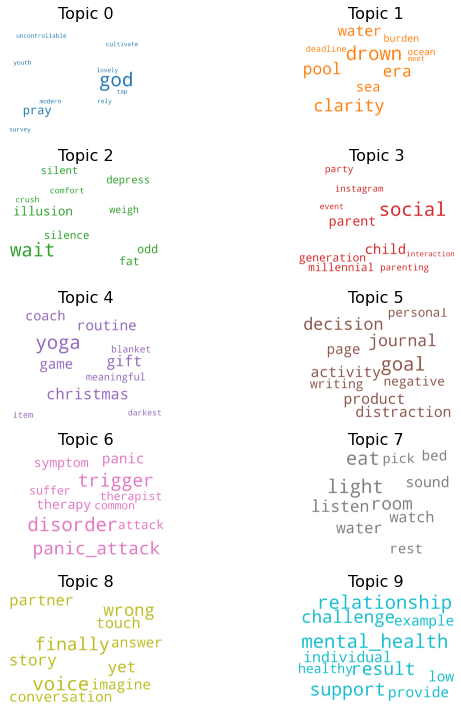

In [35]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [32]:
df_dominant_topic.to_csv("Medium2019.csv")

In [38]:
num_topics=26
topic_words = []
for i in range(num_topics):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])
for i in range(0,num_topics):
    print(topic_words[i])
    
df2=pd.DataFrame({'Year':[],'Source':[],'Topic_ID':[],'Most_freq_words':[]})
df2['Most_freq_words']=topic_words
df2 = df2.assign(Year=2014)
df2 = df2.assign(Source='Medium')
print(df2.shape)
ls=[]
for i in range(0,num_topics):
    ls.append(i)
df2['Topic_ID']=ls
df2

['die', 'sorry', 'response', 'food', 'habit', 'space', 'quality', 'ensure', 'mindful', 'threat']
['black', 'appointment', 'office', 'doctor', 'pair', 'shoot', 'visit', 'season', 'prefer', 'forever']
['medication', 'symptom', 'health', 'drug', 'treatment', 'pain', 'gut', 'doctor', 'medicine', 'effect']
['stuff', 'death', 'content', 'post', 'money', 'shit', 'ocd', 'father', 'feed', 'art']
['meditation', 'practice', 'emotion', 'tool', 'meditate', 'emotional', 'horse', 'technique', 'list', 'habit']
['social', 'child', 'parent', 'generation', 'millennial', 'party', 'instagram', 'parenting', 'event', 'interaction']
['job', 'business', 'pay', 'boss', 'interview', 'client', 'career', 'workplace', 'plan', 'professional']
['light', 'eat', 'room', 'listen', 'water', 'watch', 'sound', 'bed', 'rest', 'pick']
['wait', 'illusion', 'odd', 'fat', 'silence', 'silent', 'depress', 'weigh', 'comfort', 'crush']
['mother', 'daughter', 'weight', 'mom', 'cry', 'kid', 'eye', 'reach', 'baby', 'fight']
['voice', 

,Year,Source,Topic_ID,Most_freq_words
0,2014,Medium,0,"[die, sorry, response, food, habit, space, qua..."
1,2014,Medium,1,"[black, appointment, office, doctor, pair, sho..."
2,2014,Medium,2,"[medication, symptom, health, drug, treatment,..."
3,2014,Medium,3,"[stuff, death, content, post, money, shit, ocd..."
4,2014,Medium,4,"[meditation, practice, emotion, tool, meditate..."
5,2014,Medium,5,"[social, child, parent, generation, millennial..."
6,2014,Medium,6,"[job, business, pay, boss, interview, client, ..."
7,2014,Medium,7,"[light, eat, room, listen, water, watch, sound..."
8,2014,Medium,8,"[wait, illusion, odd, fat, silence, silent, de..."
9,2014,Medium,9,"[mother, daughter, weight, mom, cry, kid, eye,..."


In [40]:
df2.to_csv("topic_words_m2019.csv")

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=6)


range(2, 100, 6)
[0.18957779381187723, 0.24542585839654846, 0.23986521029078367, 0.23749795288379869, 0.24127681576873408, 0.23587993296746243, 0.24136837332088368, 0.2385731685902977, 0.23432428138468514, 0.23274417338830408, 0.23723927472087442, 0.2389374784699711, 0.23706915339066414, 0.23606772200185028, 0.23001182303895898, 0.23240439250343603, 0.2348172693632214]


(8, 0.05584806458467123, 0.24542585839654846)

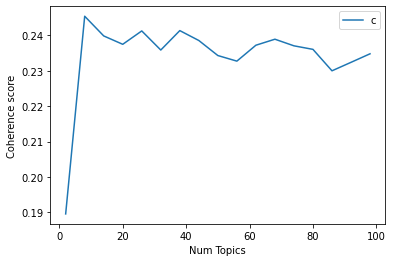

In [17]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)